Bayesian Estimation w/ PyMC and IPCluster
=====

<center>
<i>[Clayton A Davis](http://clayadavis.net), [Continuum Analytics](http://continuum.io) July 2013</i>

<a href=http://continuum.io><img style="display: block;
    margin-left: auto;
    margin-right: auto" src="https://ijstokes-public.s3.amazonaws.com/img/continuum-logo-color.png"></a>
</center>

#### Markov Chain Monte Carlo (MCMC) sampling can be used in Bayesian estimation when computing posterior probability distributions. MCMC sampling presents an ideal use case for IPCluster: it is an embarassingly parallel, CPU-limited process that involves moving relatively small amounts of data between nodes.

Among basketball fans, there is some debate over whether or not a "hot hand" is a factor in making free throws. The hot hand phenomenon refers to the supposed increased probability of making a second free throw if the player was successful in his first free throw attempt. Since free throws most often come in pairs, there are many opportunities for fans to succumb to confirmation bias whatever their stance on the issue. 

Phrased in the language of probability theory, the existence of hot hands would imply a difference in the probability of making a second free throw conditional on the outcome of the first attempt. In this notebook, we will use free throw data from the NBA 2010-2012 seasons to test this hypothesis. In order to mitigate some of the confounding factors, we will limit our analysis to single players over this two year period.

We will use MCMC Bayesian Estimation to estimate these two parameters: $\theta_0 = P(\textrm{make second free throw}|\textrm{miss first FT})$ and $\theta_1 = P(\textrm{make second FT} | \textrm{make first FT})$. Collectively, we call these estimated parameters $\theta_i$. With Bayesian estimation, our posterior estimates of these parameters come as entire distributions, not scalars, as seen in the plots below for two different players:

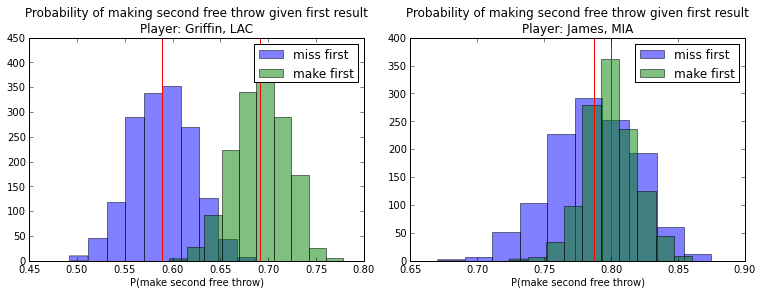

In [1]:
from IPython.core import display
display.Image(filename='two_posteriors.png')

Having these estimates as probability distributions allows us powerful uncertainty estimation for deciding whether $\theta_0$ and $\theta_1$ are credibly different. We can phrase our ultimate question regarding the existence of "hot hand" as follows: do the credible values for the quantity $\theta_1 - \theta_0$ include zero? **Spoiler alert**: as one might deduce from the above histograms, it depends on the player!
        
This notebook is designed to run in the [Wakari](https://wakari.io) analytics environment, but should run in any current-version IPython notebook with PyMC installed and `--pylab=inline` enabled. This example is inspired by one in John K. Kruschke's [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/).

In [2]:
import os
import re
import gzip
import collections

import numpy as np

## Data

Our data comes from tab-separated lists of NBA play-by-play data about free throws:

    game_id        event_idx time_left   event
    20110416ATLORL    164    00:30:06    [ATL] Crawford Free Throw 1 of 2 Missed
    20110416ATLORL    167    00:30:06    [ATL 34-35] Crawford Free Throw 2 of 2 (5 PTS)

As long as the data is sorted by columns 0 then 1 (which it is), the only information we care about is in column 3. The following function extracts these events, limiting to a particular player and/or team if desired.

In [3]:
def get_events(team='', player=''):
    events = []
    for filename in filter(lambda x: x.endswith('.gz'), os.listdir('.')):
        regex = "\[{team}.*\] {player}.*Free Throw . of 2".format(team=team, player=player)
        events += (x.split('\t')[3] for x in gzip.open(filename) if re.search(regex, x))
    return events

In order to see who might be interesting to analyze, let's list the players in our dataset who have taken the most free throws.

In [4]:
c = collections.defaultdict(int)
for event in get_events():
    rex = re.search('\[(.+)\] (.+) Free Throw', event)
    if rex:
        c[(rex.group(1), rex.group(2))] += 1
        
sorted(c.items(), key=lambda x: x[1], reverse=True)[:10]

[(('ORL', 'Howard'), 616),
 (('LAC', 'Griffin'), 404),
 (('MIA', 'James'), 253),
 (('MIA', 'Wade'), 215),
 (('SAC', 'Cousins'), 204),
 (('ATL', 'Smith'), 194),
 (('OKC', 'Westbrook'), 172),
 (('LAC', 'Jordan'), 171),
 (('NYK', 'Stoudemire'), 168),
 (('DAL', 'Haywood'), 162)]

<a name="player"></a>

Specify the team and player you want to analyze in the next cell. I recommend comparing results for `('LAC', 'Griffin')` and `('MIA', 'James')`, or any of the above players with lots of free throws.

In [5]:
team, player = ('LAC', 'Griffin')
events = get_events(team, player)

We are going to take all of the free throw data for the player and focus only on pairs of free throws (they can be taken in sets of 1, 2, and 3, but 2 is most common). 

The key of `outcomes` is (made first free throw, made second free throw).

In [6]:
outcomes = {(False,False):0, (True,False):0, (False,True):0, (True,True):0}
for ft_1, ft_2 in zip(events[:-1], events[1:]):
    if '1 of 2' in ft_1 and '2 of 2' in ft_2:
        outcomes['PTS' in ft_1, 'PTS' in ft_2] += 1
print outcomes

{(False, True): 123, (True, False): 87, (False, False): 97, (True, True): 186}


We then group the outcomes by the result of the first free throw.

In [7]:
missed_first = [0]*outcomes[False, False] + [1]*outcomes[False, True]
made_first   = [0]*outcomes[True, False]  + [1]*outcomes[True, True]

<a name="model"></a>

## Model

Data in hand, we want to use PyMC to build our model. If you imported the `ipcluster_mcmc` environment with this notebook, the following should execute without any further action. Otherwise, you may have to install PyMC with `conda install pymc` or `pip install pymc` in a shell terminal, or else use your package manager.

In [8]:
import pymc

/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/argparse.pyc, but /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


The next cell has a lot going on, but can be broadly understood as the following:

#### 1. Priors
Thetas $\theta_0$ and $\theta_1$ are the probabilities of making the second free throw given that the first free throw was missed or made, respectively. The 30 and 10 in the `pymc.Beta('theta_%i' % i, 30, 10)` represent our prior knowledge about NBA free throws: players make about 75% ($\frac{30}{30+10}$) of their free throws. These $\theta_i$ are the quantities we will be estimating, specifically their difference $\theta_1 - \theta_0$, and whether or not that difference is credibly different from zero.

#### 2. Likelihood
In order to calculate a likelihood distribution, we model each second free throw as a Bernoulli random variable, with a probability $\theta_0$ or $\theta_1$ of going in, determined by the result of the first free throw. This dependency is specified by the `p=thetas[0]` or `p=thetas[1]`. But we know the outcomes of these "random" processes, they make up our data! So we specify `observed=True` and supply the observed value `value=result` from our data.

#### 3. PyMC model
With the prior and likelihood distributions in hand, we can combine them to obtain our posterior probability distribution. This is the distribution of credibility for the various parameter values, namely $\theta_i$, given the data we observed. The most credible values from this distribution then provide our estimates for $\theta_i$. The components of the model and their relationships are compiled into a PyMC model, and we run a MCMC sampler to characterize the posterior distribution. In the `mcmc.sample` statement, `iter` is the number of samples to take, `burn` is the number of samples to discard from the beginning of the process, and `thin` tells the sampler to keep every nth sample.

#### 4. Extract traces
After the MCMC sampling, we want to extract the "traces" of the estimated quantities. These can be thought of as roughly independent random samples from the posterior probability distribution we're interested in.

**Note:** The next two cells need to be executed one immediately after the other. We're going to save the contents of the first cell to a file to run on cluster nodes later.

In [17]:
# 1. Priors
thetas = [pymc.Beta('theta_%i' % i, 30, 10) for i in [0,1]]

# 2. Likelihood
second_shot_missed_first = [pymc.Bernoulli('shot0_%i' % i, p=thetas[0], value=result, observed=True) 
                            for i, result in enumerate(missed_first)]

second_shot_made_first   = [pymc.Bernoulli('shot1_%i' % i, p=thetas[1], value=result, observed=True) 
                            for i, result in enumerate(made_first)]

# 3. PyMC model
model = pymc.Model(thetas, second_shot_missed_first, second_shot_made_first)
mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000, burn=1000, thin=10)

# 4. Extract traces
theta_0_trace = mcmc.trace('theta_0')[:]
theta_1_trace = mcmc.trace('theta_1')[:]

 [-----------------100%-----------------] 10000 of 10000 complete in 20.4 sec

In [10]:
# Make sure this is executed immediately after the above cell!
# The -l 1 argument means save the last 1 executed cells.
%history -f hothand_model.py -l 1

File u'hothand_model.py' exists. Overwrite? no
Aborting.


## Results, serial

Since the traces represent samples from the posterior probability distribution, we can make a histogram of the likely values for $\theta_i$.

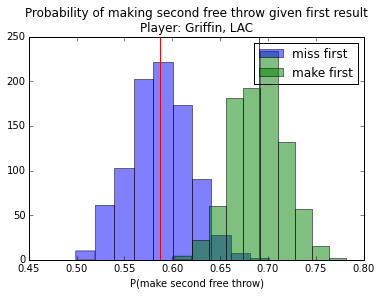

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for trace, label in zip([theta_0_trace, theta_1_trace], ['miss first', 'make first']):
    plt.hist(trace, alpha=0.5, label=label)
    plt.axvline(x=trace.mean(), c="red")
plt.legend()
player_str = "Player: {player}, {team}".format(player=player, team=team)
plt.title("Probability of making second free throw given first result\n" + player_str)
plt.xlabel("P(make second free throw)")

The Highest Density Interval, or HDI, is roughly analogous to a frequentist Confidence Interval. We can think of this as a "range of credible values". A 95% HDI is the smallest width interval to contain 95% of the posterior probability.

In [12]:
def hdi(trace, cred_mass=0.95):
    hdi_min, hdi_max = pymc.utils.calc_min_interval(np.sort(trace), 1.0-cred_mass)
    return hdi_min, hdi_max

To answer the question of whether $\theta_1 \stackrel{?}{=} \theta_0$, we can look at the difference of their traces. If zero is not a credible value, i.e. the HDI doesn't contain zero, then we can say that indeed  $\theta_1 \neq \theta_0$.

Plotting theta_0
Plotting theta_1


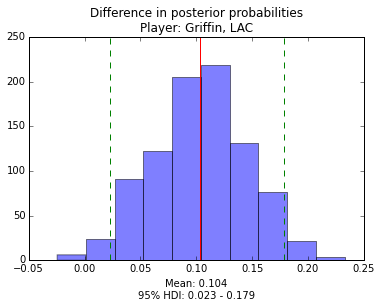

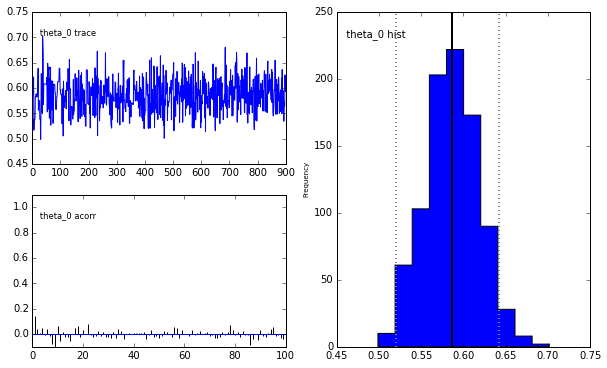

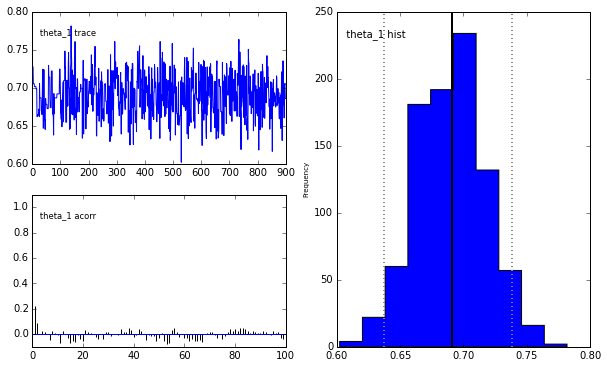

In [18]:
diff_trace = theta_1_trace - theta_0_trace
plt.hist(diff_trace, alpha=0.5)
plt.axvline(x=diff_trace.mean(), c="red")

hdi_min, hdi_max = hdi(diff_trace)
opts = {'c':'green', 'linestyle':'--'}
plt.axvline(x=hdi_min, **opts)
plt.axvline(x=hdi_max, **opts)

plt.title("Difference in posterior probabilities\n" + player_str)
plt.xlabel("Mean: {:0.3f}\n95% HDI: {:0.3f} - {:0.3f}".format(
    diff_trace.mean(), hdi_min, hdi_max))

pymc.Matplot.plot(mcmc)

The above plot gives an answer to the question of whether or not this player has a hot hand. However depending on the player and on the random walks in the MCMC sample, this posterior estimate can look a bit jagged. To visualize why, we can draw a scatterplot of the individual samples for $\theta_1$ vs $\theta_0$. The dotted line is the $x=y$ line, so if most of the points are on one side of the line, the $\theta_i$ are probably not equal.

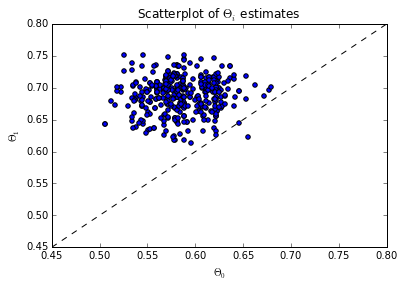

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(theta_0_trace, theta_1_trace)
ax_lim = ax.axis()
low, high = min(ax_lim[0], ax_lim[2]), max(ax_lim[1], ax_lim[3])
ax.plot([low, high], [low, high], color='k', linestyle='--', linewidth=1)
ax.set_xlim(low, high)
ax.set_ylim(low, high)
ax.set_xlabel('$\Theta_0$')
ax.set_ylabel('$\Theta_1$')
ax.set_title("Scatterplot of $\Theta_i$ estimates")

With `iter=5000, burn=1000, thin=10`, this scatterplot is a little sparse. As is the case with any random sampling scheme, our estimate is improved by more samples, so we'd like more MC steps. In order to more quickly generate MC steps, we can utilize IPCluster to farm out the computation to multiple remote nodes.

## IPCluster

The first step in working with IPCluster is to set up a controller and some engines. Follow these steps to start some engines on the local machine:

0. If you are in Wakari and you are not in the workbench view (i.e. there are no tabs above this notebook), save this notebook, then click View $\rightarrow$ Workbench in the upper right corner.
1. Open a shell terminal.
2. Make sure PyMC is installed in the current environment by running `python -c "import pymc"` . No output means PyMC is installed; if it raises an error try the following:
    * If you are in Wakari and imported the `ipcluster_mcmc` environment with this notebook, select it in the environment dropdown box and click "+Tab" like so:
        
        <center>
        ![Alt text](https://s3.amazonaws.com/webby_icons/wakari-toolbar-new.png)
        </center>
        
    * If you are in Wakari and don't have the `ipcluster_mcmc` environment, or you are running locally with Anaconda, run `conda install pymc`
        
    * If you are running locally without Anaconda, use `pip install pymc` or your package manager.

3. Execute `ipcluster start -n 2`

The `-n` option specifies how many engines to run. Advanced configuration, e.g. employing engines on remote machines, is nontrivial and beyond the scope of this notebook. Later, take a look at Min RK's [documentation](http://minrk.github.io/scipy-tutorial-2011/parallel_process.html) and/or Ian Stokes-Rees's [notebook](https://www.wakari.io/sharing/bundle/ijstokes/ipcluster-wakari-intro) for examples and information on more sophisticated IPCluster setups.

In [15]:
# This is to keep people who "Run All Cells" from getting errors at the next step.
try:
    client
except NameError:
    raise Exception("Read the cell above before continuing through this notebook.")

Exception: Read the cell above before continuing through this notebook.

First we need to create a client object. Depending on your configuration, you may have to supply options to the `Client` object's init. The default local ipcluster configuration needs no such options.

In [ ]:
from IPython.parallel import Client
client = Client()

After creating a client object, we need to get a view. We are going to use the direct view, which means that commands always run on all nodes. This as opposed to a balanced view, which asynchronously executes code on nodes which are idle. In addition, we are going to turn blocking on. This means that jobs will block further execution until all nodes have finished.

In [ ]:
direct         = client[:]
direct.block   = True

If you get an error from the above cell, make sure your IPCluster engines are up and running. Sometimes engines on remote nodes can take 30-120 sec to start and become connectable.

Let's check that our remote nodes are running and connected by running a simple test command on each:

In [ ]:
def checkhostname():
    import socket
    return socket.gethostname()

direct.apply(checkhostname)

## PyMC on IPCluster

Our remote nodes have separate namespaces from the controller node that this notebook is running on. As such we need to make sure we have the imports we require...

In [ ]:
with direct.sync_imports():
    import pymc

...and we need to push our processed data over to the remote nodes as well. Ideally we would push the `pymc.model` object, but only picklable objects can be pushed.

In [ ]:
export_dict = {k: globals()[k] for k in ('missed_first','made_first')}
direct.push(export_dict, block=True)

Recall that we used `%history` magic to save the contents of the model definition cell. Let's load that up and make sure that it saved the right thing.

In [ ]:
model_script = open('hothand_model.py').read()
print model_script

The script to define and run the PyMC model should have printed out above. If it didn't, run the cells in the <a href='#model' target='_self'>Model</a> section again.

We can then execute this script on the remote machines to generate traces. Recall we set `direct.block = True`, so this will block for a minute or two while the engines generate MC chains.

In [ ]:
direct.execute(model_script)

After generating the traces on the remote nodes, we can pull them back and combine them with the traces we computed earlier on this node.

In [ ]:
theta_0_traces = direct.pull('theta_0_trace') + [theta_0_trace]
theta_1_traces = direct.pull('theta_1_trace') + [theta_1_trace]

With this larger set of traces, our estimates will be better. Of course, being able to run multiple chains in parallel means that you can run each for a shorter amount of time, speeding up the overall process.

## Results, parallel

Our earlier plotting code can be mostly reused, we just need to flatten out our trace arrays first.

In [ ]:
traces = [np.array(t).flatten() for t in [theta_0_traces, theta_1_traces]]

for trace, label in zip(traces, ['miss first', 'make first']):
    plt.hist(trace, alpha=0.5, label=label)
    plt.axvline(x=trace.mean(), c="red")

plt.legend()
plt.title("Probability of making second free throw given first result\n" + player_str)
plt.xlabel("P(make second free throw)")

Now that we have 3x as many samples drawn from the posterior, this plot probably looks smoother than the analogous one from the serial results before. Similarly we expect the next plot of the difference $\theta_1 - \theta_0$ to be smoother.

In [ ]:
diff_trace = traces[1] - traces[0]

plt.hist(diff_trace, alpha=0.5)
plt.axvline(x=diff_trace.mean(), c="red")

hdi_min, hdi_max = hdi(diff_trace)
opts = {'c':'green', 'linestyle':'--'}
plt.axvline(x=hdi_min, **opts)
plt.axvline(x=hdi_max, **opts)

plt.title("Difference in posterior probabilities\n" + player_str)
plt.xlabel("Mean: {:0.3f}\n95% HDI: {:0.3f} - {:0.3f}".format(
    diff_trace.mean(), hdi_min, hdi_max))

The mean and HDI reported here may be slightly different from those in the analogous plot from before. This is a better estimate of those quantities, based on more samples.

In [ ]:
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_subplot(111)

#Plot each chain in a different color!
colors = mpl.cm.rainbow_r(np.linspace(0,1,len(theta_0_traces)))
for t_0, t_1, color in zip(theta_0_traces, theta_1_traces, colors):
    ax.scatter(t_0, t_1, c=color, alpha=0.5)

ax_lim = ax.axis()
low, high = min(ax_lim[0], ax_lim[2]), max(ax_lim[1], ax_lim[3])
ax.plot([low, high], [low, high], color='k', linestyle='--', linewidth=1)
ax.set_xlim(low, high)
ax.set_ylim(low, high)
ax.set_xlabel('$\Theta_0$')
ax.set_ylabel('$\Theta_1$')
ax.set_title("Scatterplot of $\Theta_i$ estimates")

In the above scatterplot, the traces from the remote nodes are plotted in different colors, but they are all being drawn from the same posterior distribution. The increased density of this plot as compared to the earlier scatterplot is the reason for the increased smoothness of the previous two plots.

#### Now try it again with a different player! Go back to <a href="#player" target="_self">this cell</a>, change the team and player name, then click Cell $\rightarrow$ Run All Below.

## Conclusions and Next Steps

This analysis seems to suggest that a hot hand is a factor for some players, while possibly not a factor for others. Confounding factors abound, however, so this conclusion should be taken with a grain of salt.

Independent of the existence of hot hand or lack thereof, we have demonstrated a basic IPCluster workflow with a nontrivial example. MCMC sampling of the posterior distribution is an ideal task for this type of parallelism, an embarassingly parallel task with large CPU demand and relatively small data transport. Many scientific workflows fit this pattern and could thus benefit from IPCluster's convenient implementation. For IPCluster jobs such as this one, consider [Wakari's](https://wakari.io) "Add Compute Nodes" functionality to spin up additional compute engines on demand -- this functionality is demonstrated in Ian Stokes-Rees's [excellent notebook](https://www.wakari.io/sharing/bundle/ijstokes/ipcluster-wakari-intro) where he demonstrates more sophisticated uses and configurations for IPCluster.

For other featured notebooks, check out the [Wakari Notebook Gallery](https://www.wakari.io/gallery)! And for more on Bayesian methods, take a look at John K. Kruschke's [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/).

 

&copy;2013 [Continuum Analytics](http://continuum.io)

